<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_10/Final_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Change Runtime Type to GPU

> Runtime > Change runtime type > Hardware Accelerator > GPU

In [6]:
# !pip install bertopic

## Likely you'll need additional libraries, refer to Module 9 notebooks. 


---



In [3]:
# load our libraries 
import warnings
warnings.filterwarnings('ignore')

# standard libries
import gzip
import json
import urllib.request
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import random 
import string
import re

# BERT Topic
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, models

# nltk, gensim, pprint and wordclouds  
import nltk
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from pprint import pprint


## Tweet Data


In [4]:
# Load Tweets
tweets = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_10/trump_tweets.csv",
                      parse_dates=["tweet_date", "tweet_timestamp"])


# tweets = tweets.query("is_retweet == False")
tweets.head()


,tweet_id,tweet_text,is_retweet,is_deleted,device,favorites,retweets,tweet_timestamp,is_flagged,tweet_date
0,9.845500e+16,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02 18:07:48+00:00,False,2011-08-02
1,1.234650e+18,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50+00:00,False,2020-03-03
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47+00:00,False,2020-01-17
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58+00:00,False,2020-09-12
4,1.220000e+18,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17 13:13:59+00:00,False,2020-01-17


In [5]:
tweets.shape

(56571, 10)

In [7]:
tweets.describe()

,tweet_id,favorites,retweets
count,5.657100e+04,5.657100e+04,56571.000000
mean,7.987897e+17,2.834955e+04,8618.987467
std,3.826678e+17,5.781564e+04,13306.132408
min,1.698309e+09,0.000000e+00,0.000000
25%,4.606190e+17,1.000000e+01,59.000000
50%,7.470990e+17,1.640000e+02,3450.000000
75%,1.191705e+18,4.393850e+04,13014.500000
max,1.350000e+18,1.869706e+06,408866.000000


## Sentiment Datasets

In [8]:
afinn = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/Afinn.csv", encoding='ISO-8859-1')
print(afinn.head())
bing = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/Bing.csv", encoding='ISO-8859-1')
print(bing.head())
nrc = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/NRC.csv", encoding='ISO-8859-1')
print(nrc.head())

        word  value
0    abandon     -2
1  abandoned     -2
2   abandons     -2
3   abducted     -2
4  abduction     -2
         word sentiment
0     2-faces  negative
1    abnormal  negative
2     abolish  negative
3  abominable  negative
4  abominably  negative
        word sentiment
0     abacus     trust
1    abandon      fear
2    abandon  negative
3    abandon   sadness
4  abandoned     anger


# Example Term Breakdown


---



In [16]:
# Term table 
tweet_terms = (tweets["tweet_text"]
               .str.lower()  # convert to lowercase
               .str.split()  # split into individual words
               .explode()    # explode into separate rows
               .to_frame(name="term")  # convert to DataFrame with column name "term"
)
tweet_terms.head()

,term
0,republicans
0,and
0,democrats
0,have
0,both


# Summarize Terms into Term Frequency


---



In [17]:
term_freq_w_junk = (tweet_terms
            .groupby("term")
            .size()
            .reset_index()
            .rename(columns={0: "freq"})
            .sort_values("freq", ascending=False)
            .dropna()
            .reset_index(drop=True)
            )
term_freq_w_junk.head(10)

,term,freq
0,the,44823
1,to,25978
2,and,20299
3,a,18610
4,of,17860
5,is,15778
6,in,15357
7,for,12651
8,i,10314
9,on,9845


# wordcloud of junk


---

Here's my junk wordcloud

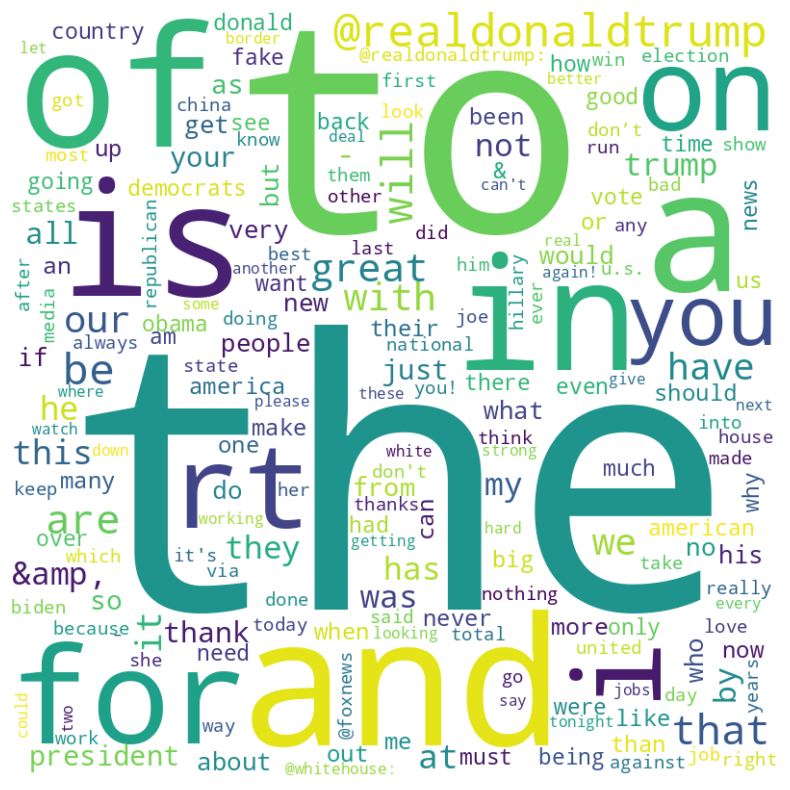

In [20]:
# Create a dictionary of terms and frequencies
term_freq_w_junk_dict = dict(zip(term_freq_w_junk['term'], term_freq_w_junk['freq']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(term_freq_w_junk_dict)

# Display the word cloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
import re
tweets["year_month"] = tweets["tweet_date"].dt.strftime("%Y-%m")
# split the review text into individual words and explode the resulting Series of lists
tweet_terms = (tweets
                .query("tweet_date >= '2015-01-01' and tweet_date < '2017-01-01'")[["year_month","tweet_text"]] 
              .assign(review_text=tweets['tweet_text']
                     .str.lower()
                     .apply(lambda x: re.sub('\s+', ' ', x.translate(str.maketrans('', '', string.punctuation)).strip()))
                     .str.split())
             .explode('review_text')
             .reset_index(drop=True)
             .dropna()
             .rename(columns={"review_text":"term"})
             )
tweet_terms.head()
step_2 = (tweet_terms
          .groupby(["year_month", "term"])
          .count()
          .reset_index()
          .rename(mapper={"tweet_text": "freq"}, axis=1)
          .sort_values(["year_month", "freq"], ascending=False)
         )

step_2

,year_month,term,freq
52911,2016-12,the,120
52941,2016-12,to,78
52131,2016-12,and,59
52692,2016-12,of,56
52531,2016-12,in,46
...,...,...,...
3917,2015-01,😘,1
3918,2015-01,😘😘😘,1
3919,2015-01,😡,1
3920,2015-01,😩,1


In [27]:
step_2.query("term == 'fake'")

,year_month,term,freq
52366,2016-12,fake,1
42208,2016-06,fake,2
35095,2016-02,fake,1
27642,2015-11,fake,2
24581,2015-10,fake,3
17533,2015-07,fake,2
14876,2015-06,fake,1
12073,2015-05,fake,1
